# 0. Imports

In [103]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
import optuna
import os
import joblib
import shap
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, recall_score, precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import issparse

# 1. Analise Exploratória dos Dados

## 1.1 Informações gerais da tabela

Como o dataset de treino não possui a feature classe, e já que não estamos praticando aqui o uso de aprendizado não supervisionado, ela não possui muito uso em nosso treinamento. Em cenários reais o ideal é que estivesse tudo junto para que fosse feito o split da forma metódica, por isso usaremos somente Train_data

In [104]:
df = pd.read_csv('Train_data.csv')

In [105]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

Checando para valores null

In [106]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

Checando duplicatas

In [107]:
df.duplicated().values.any()

np.False_

Como conclusão parcial temos que o dataset por si já veio bem tratado, então vamos executar uma analise exploratória mais voltada a redução de dimensionalidade, isto é, diminuir a quantidade de colunas que não implicam muito no resultado do machine learning. Para isso precisamos ter uma visualização melhor do dataset

## 1.2 Análise das features categóricas

<Axes: xlabel='class', ylabel='count'>

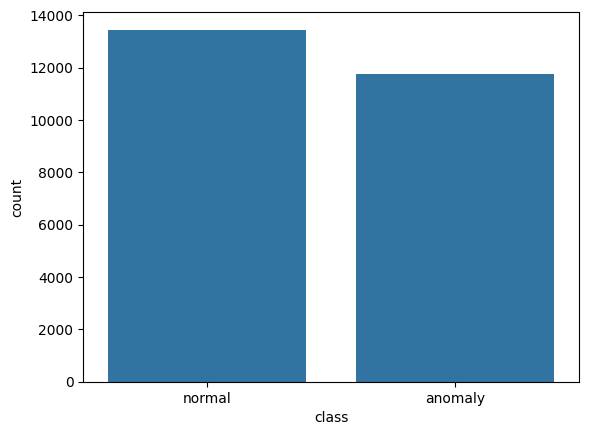

In [108]:
sns.countplot(x=df['class'])

É possível concluir a partir deste gráfico que o quantitativo de casos em cada classe, que é nossa variável alvo pro modelo de inferência é bem balanceada, o q implica que a nossa acurácia de modelo pode ser usada como uma boa métrica de performance, a pequena diferença de 3% entre cada não justifica um oversampling ou o uso de amostras de teste.

<Axes: xlabel='protocol_type', ylabel='count'>

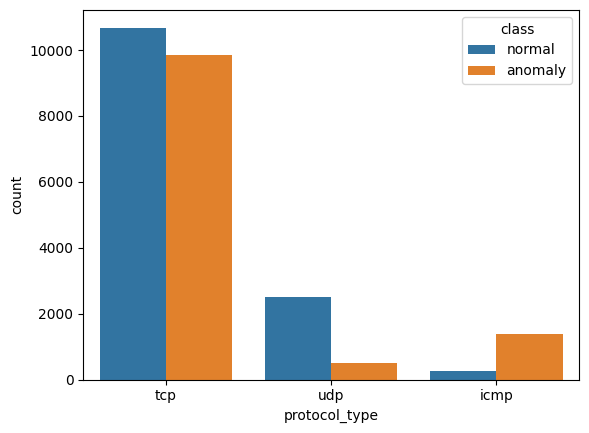

In [109]:
sns.countplot(data = df, x ='protocol_type', hue = 'class')

80% do tráfego é TCP, enquanto 12% é do UDP e o resto ICMP;
Boa parte do tráfego em ICMP tinha alguma anomalia, enquanto o UDP é boa parte normal;
Ao todo, há mais casos normais presentes em TCP e UDP comparado à anomalias, no entanto a diferença numérica de classes em TCP é bem menor comparada aos outros, o q dificulta um pouco a inferência sem outras matrizes de correlação, o que iremos explorar mais abaixo.

<Axes: xlabel='flag', ylabel='count'>

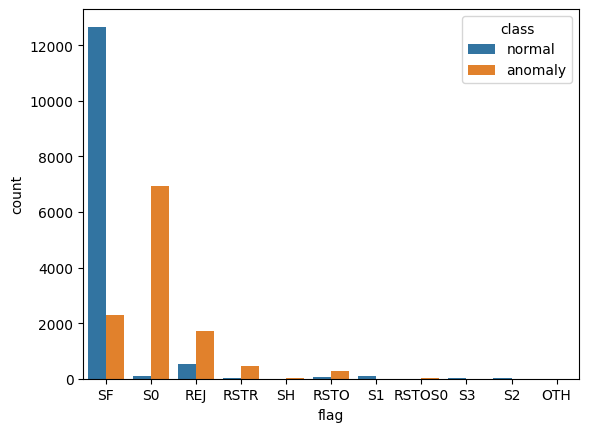

In [110]:
sns.countplot(data = df, x = 'flag', hue = 'class')

A distribuição de trafego baseada nas flags é bem desigual também, onde maioria é de tipo Sign Flag(SF). Boa parte do mesmo é normal, enquanto S0 é de maioria anomala.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65],
 [Text(0, 0, 'ftp_data'),
  Text(1, 0, 'other'),
  Text(2, 0, 'private'),
  Text(3, 0, 'http'),
  Text(4, 0, 'remote_job'),
  Text(5, 0, 'name'),
  Text(6, 0, 'netbios_ns'),
  Text(7, 0, 'eco_i'),
  Text(8, 0, 'mtp'),
  Text(9, 0, 'telnet'),
  Text(10, 0, 'finger'),
  Text(11, 0, 'domain_u'),
  Text(12, 0, 'supdup'),
  Text(13, 0, 'uucp_path'),
  Text(14, 0, 'Z39_50'),
  Text(15, 0, 'smtp'),
  Text(16, 0, 'csnet_ns'),
  Text(17, 0, 'uucp'),
  Text(18, 0, 'netbios_dgm'),
  Text(19, 0, 'urp_i'),
  Text(20, 0, 'auth'),
  Text(21, 0, 'domain'),
  Text(22, 0, 'ftp'),
  Text(23, 0, 'bgp'),
  Text(24, 0, 'ldap'),

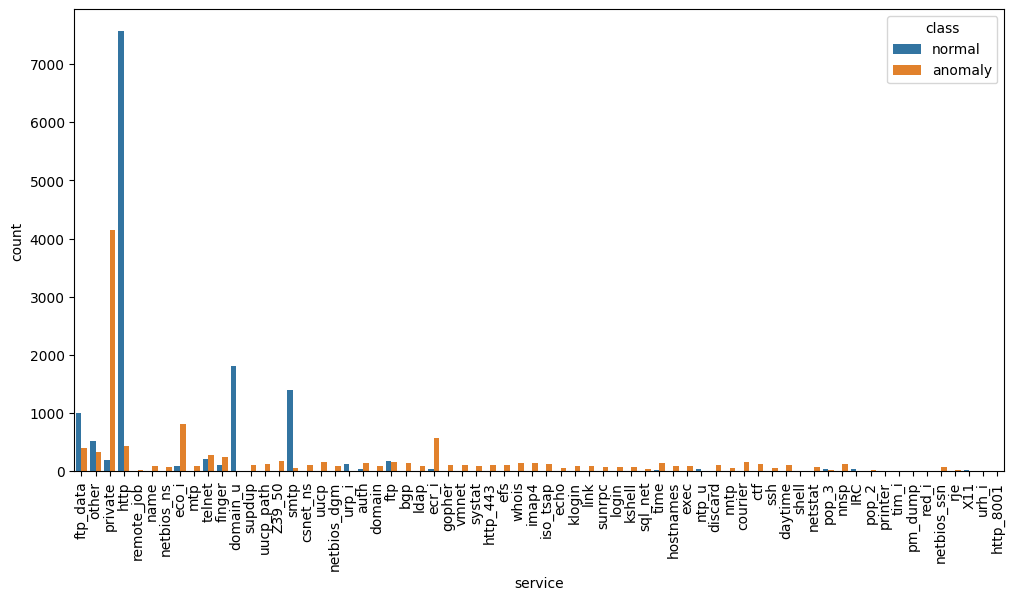

In [111]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'service', hue = 'class')
plt.xticks(rotation = 90)

Inicialmente meu plano incluia derrubar essa coluna, já que como vemos pelo gráfico ela possui uma alta quantidade de classes em sua feature(66 pra ser exato) porém enquanto lendo sobre o assunto em cenários reais mostra o quão importante é o tipo de serviço em KDD(Knowledge Discovery in Database) para detecção de ataques, então vamos tratar sobre isso mais abaixo.

https://www.researchgate.net/publication/361531767_Establishing_the_Contaminating_Effect_of_Metadata_Feature_Inclusion_in_Machine-Learned_Network_Intrusion_Detection_Models

<Figure size 1600x600 with 0 Axes>

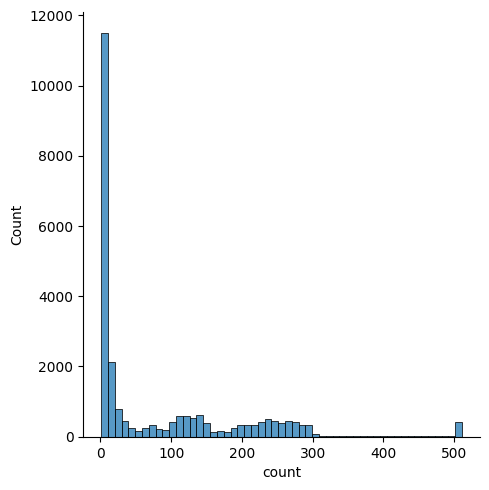

In [112]:
plt.figure(figsize=(16,6))
sns.displot(df['count'], kde=False)

Count demonstra que maioria das conexões possuiam o mesmo host de destinação usando o mesmo serviço, sendo ou com count MUITO baixo, ou count MUITO alto.

## 1.3 Análise das features numéricas

In [113]:
labels ={'normal':0,'anomaly':1}
df['class'] = df['class'].map(labels)

Aqui estamos simplesmente fazendo um encoding simples, isto é, mudando uma classe categórica para uma númerica para a alimentação do nosso modelo, sendo 0 uma atividade normal e 1 uma atividade anomala.

In [114]:
num_cols = df.select_dtypes(include = ['int64','float64'])

Aqui buscamos todas as classes númericas, como temos muitas colunas numéricas o nosso objetivo aqui é reduzir a dimensionalidade, isto é, uma técnica de ML feita para aumentar a capacidade de inferência do nosso modelo retirando colunas que causem ruído, nesse caso vamos tirar colunas que uma alta correlação que possuam o mesmo resultado de classe assim criando um modelo um pouco mais robusto.

In [115]:
num_cols.corr()['class'].sort_values()

same_srv_rate                 -0.749237
dst_host_srv_count            -0.719292
dst_host_same_srv_rate        -0.692212
logged_in                     -0.688084
srv_diff_host_rate            -0.120649
is_guest_login                -0.038662
num_access_files              -0.036999
su_attempted                  -0.025851
num_root                      -0.019753
num_compromised               -0.018620
root_shell                    -0.018579
num_file_creations            -0.018322
num_shells                    -0.013454
hot                           -0.012839
dst_bytes                     -0.010949
num_failed_logins              0.000028
land                           0.000605
srv_count                      0.002370
src_bytes                      0.005743
urgent                         0.006743
duration                       0.050901
dst_host_srv_diff_host_rate    0.062928
dst_host_same_src_port_rate    0.092974
wrong_fragment                 0.097625
diff_srv_rate                  0.193528


In [116]:
df.drop(['num_outbound_cmds','is_host_login'], axis=1, inplace=True)
num_cols = df.select_dtypes(include = ['int64','float64'])

Como visto acima, essas duas features 'num_outbound_cmds','is_host_login' não implicam em nada(na verdade, após olhar elas não possuem nenhum valor registrado) no modelo, por isso podemos retira-las imediatamente.

<Axes: >

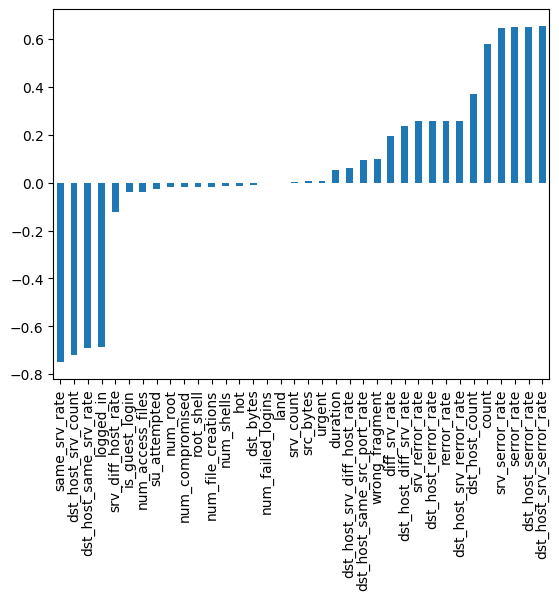

In [117]:
num_cols.corr()['class'].drop('class').sort_values().plot(kind ='bar')

No gráfico vemos uma alta correlação negativa de -0.749 que sugere uma relação inversa entre 'same_srv_rate' e nossa variável alvo 'classe' o que indica que assim que os valores delas são mais altos, é mais indicavel que aquela seja uma atividade anomala, e vice versa. Enquanto isso, uma correlação positiva alta de 0.65 entre 'dst_host_srv_serror_rate' e nossa variável alvo diz que quanto maior o valor dele, maior a chance de ser uma anomalia.

### 1.3.1 Tratamento de features numéricas correlacionadas

<Axes: >

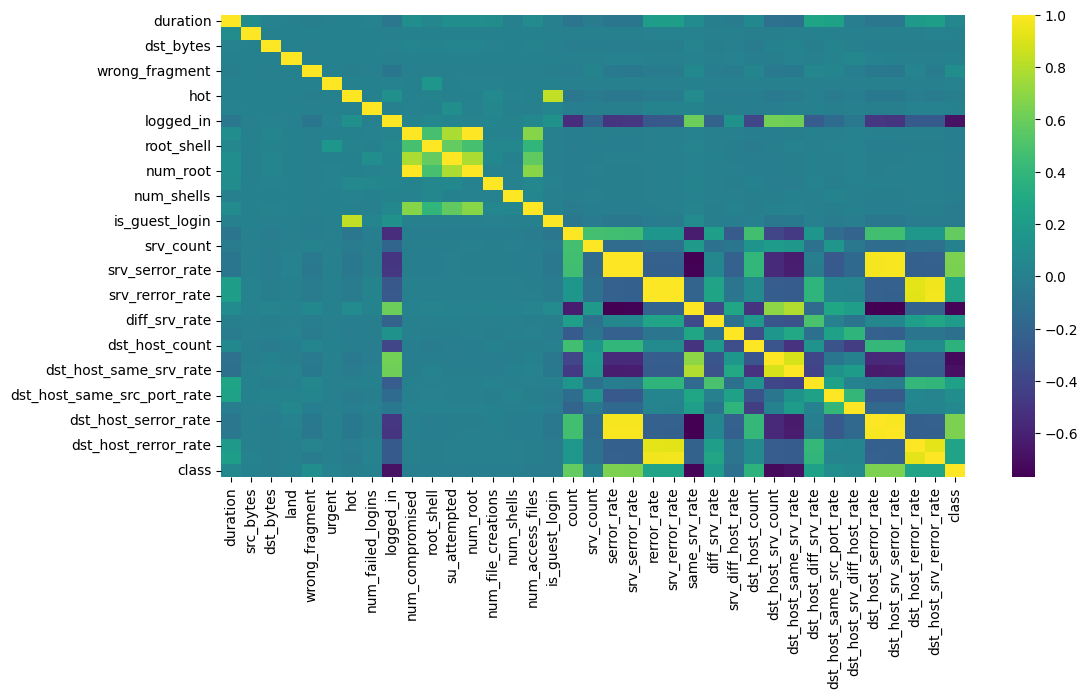

In [118]:
plt.figure(figsize = (12, 6))
sns.heatmap(data = num_cols.corr(), cmap = 'viridis')

Aqui estamos vendo uma matriz de correlação de variáveis, aqui podemos ver quais variáveis tem maior relação entre si na implicação do resultado, assim podemos eliminar a redundância criando uma matriz entre essas variáveis e retirando uma delas.

In [119]:
# Calculando a matriz de correlação
correlation_matrix = num_cols.corr()

# Limite de correlação mínima para matriz
threshold = 0.90

# Array de pares de correlação direta
strong_correlations = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            strong_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convertido em dataframe para legibilidade
strong_correlations_df = pd.DataFrame(strong_correlations, columns=['Feature 1', 'Feature 2', 'Correlation Coefficient'])

strong_correlations_df

,Feature 1,Feature 2,Correlation Coefficient
0,num_root,num_compromised,0.998956
1,srv_serror_rate,serror_rate,0.993290
2,srv_rerror_rate,rerror_rate,0.989134
3,dst_host_serror_rate,serror_rate,0.978022
4,dst_host_serror_rate,srv_serror_rate,0.976363
5,dst_host_srv_serror_rate,serror_rate,0.979602
6,dst_host_srv_serror_rate,srv_serror_rate,0.984621
7,dst_host_srv_serror_rate,dst_host_serror_rate,0.984706
8,dst_host_rerror_rate,rerror_rate,0.928992
9,dst_host_rerror_rate,srv_rerror_rate,0.919537


In [120]:
strong_correlations_list = list(strong_correlations_df['Feature 1'])
strong_correlations_list

['num_root',
 'srv_serror_rate',
 'srv_rerror_rate',
 'dst_host_serror_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'dst_host_srv_rerror_rate',
 'dst_host_srv_rerror_rate']

Como dito anteriormente, essas variáveis possuem mais de 90% de relação entre si, então retira-las é uma forma de aumentarmos a robustez de nosso modelo diminuindo a dimensionalidade da tabela.

In [121]:
df = df.drop(strong_correlations_list, axis = 1)

## 1.4 Tratamento de outliers

Aqui fariamos o tratamento de outliers usando o método interquartis, porém em uma verificação rápida não existem outliers suficientes para justificar esse tratamento, então podemos simplesmente pular isso

In [122]:
def take_outliers_out(df:pd.DataFrame, num_features:list)->pd.DataFrame:
    for variable in num_features:
        var_desc = df[variable].describe() 
        IQR = var_desc['75%'] - var_desc['25%']
    
        new_df = df[(df[variable] <= (var_desc['75%'] + 2 * IQR)) & (df[variable] >= (var_desc['25%'] - 2 * IQR))]
    
    return new_df

In [123]:
#df = take_outliers_out(df, num_cols)
#df.reset_index(drop=True, inplace=True)

# 2. Modelagem

## 2.1 Codificação de features categóricas

Aqui começamos separando a tabela com nossas features e nossa variável alvo.

In [124]:
y  = df['class']
X  = df.drop(columns='class')

In [125]:
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object','category']).columns.tolist()

Por que não usamos somente o OneHotEncoding ou diretamente o label encoder aqui?

Isso é possível, porém não tão performático primeiro pelas dimensões de colunas, que machucariam a acurácia no one hot encoding/label encoder assim como o fator cardinalidade para ordenalidade caso fosse feito assim já que 'service' tem 66 valores únicos mas que não representam diretamente ordinalidade quanto a presença de uma anomalia ou não. Por isso a separação abaixo.

Um fator que seria um ponto de melhoria aqui seria o fato de de classes de distribuição de cauda pesada, como foi visto acima com o exemplo do count(na verdade, todas que possuem count no descritivo são de cauda pesada) o que implica num alto enviesamento dos dados. O ideal portanto seria que fosse feito uma transformação logarítmica(mas são 15:39 de um domingo e eu quero assistir formula 1) para lidar com a alta variabilidade e assimetria de counts de forma performática.

In [126]:
svc_col   = ['service']
cat_ohcol = [c for c in cat_cols if c not in svc_col]

prep = ColumnTransformer([
        ('svc', TargetEncoder(
                    cols=svc_col,
                    smoothing=0.3,
                    handle_unknown='ignore',
                    handle_missing='value'), svc_col),


        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_ohcol),


        ('num', StandardScaler(), num_cols)
])

## 2.2 Separação de treino e teste

Aqui é um split básico de 80/20 entre treino e teste para os nossos modelos

In [127]:
X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42)


# 3. Classificação

## 3.1 Classificação com o XGB

Por que usamos XGB aqui? Por conta das diversas relações não diretamente lineares como visto acima nas features 'service' e 'flag' assim como melhor adequação a features com e sem cardinalidade assim como mais eficiente energéticamente para ambientes reais da industria.

In [128]:
clf = XGBClassifier(
        n_estimators    = 200,
        max_depth       = 6,
        learning_rate   = 0.10,
        subsample       = 0.8,
        colsample_bytree= 0.8,
        objective       = 'binary:logistic',
        eval_metric     = 'logloss',
        n_jobs          = 4,
        scale_pos_weight= (len(y[y==0]) / len(y[y==1]))   # 0=normal,1=anomalia
)

In [129]:
pipe = Pipeline([
        ('prep',  prep),
        ('model', clf)
])

pipe.fit(X_tr, y_tr)

y_pred = pipe.predict(X_te)
y_prob = pipe.predict_proba(X_te)[:, 1]  # probabilidade da classe 1 anomalia

### 3.1.1 Resultados com o XGB Padrão 

Para calcular melhor o sucesso do nosso modelo temos de ter noção que o custo das predições é diferente, isso será explorado melhor nas modelagens abaixo mas em tese temos que: ataques nos quais nosso modelo não detecta, isto é falsos negativos, claramente impactam mais que um alarme falso(falso positivo), então devemos trabalhar para otimizar ao máximo falsos negativos. Ademais, acurácia pura não serve como métrica nesse modelo, tendo em vista isso precisamos saber da sensibilidade(descrito como recall) do modelo, que mede quantas instâncias positivas reais o modelo conseguiu indentificar.

Além disso precisamos saber o a taxa de verdadeiros positivos contra a taxa de falsos positivos, que é conhecido como ROC-AUC(Receiver Operating Characteristic per Area Under the Curve), quanto mais próximo ao 1 melhor, e também a PR-AUC(Precision-Recall per Area Under the Curve) exclusivamente para a qualidade em dettecção de ataques, que demonstra caso haja um desbalanceamento entre ataques e detecções normais.

In [130]:
print(metrics.classification_report(
        y_te, y_pred, target_names=['normal','anomaly']))
print("ROC‑AUC :", metrics.roc_auc_score(y_te, y_prob))
print("PR‑AUC  :", metrics.average_precision_score(y_te, y_prob))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      2690
     anomaly       1.00      0.99      1.00      2349

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039

ROC‑AUC : 0.999963917256572
PR‑AUC  : 0.9999592002036012


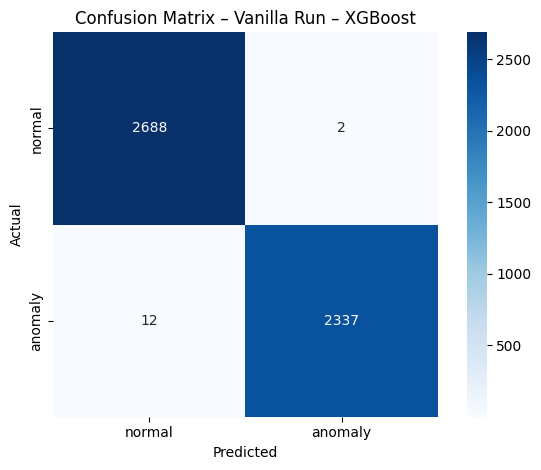

In [131]:
cm = metrics.confusion_matrix(y_te, y_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal','anomaly'],
            yticklabels=['normal','anomaly'],
            square=True)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix – Vanilla Run – XGBoost'); plt.tight_layout(); plt.show()

## 3.2 Classificação com XGB com Otimização de Hiperparâmetros

O que estamos fazendo aqui?
Aqui utilizamos o optuna para rodar varias iterações do modelo pra procurar um conjunto de parâmetros que em cada verificação atinja pelo o menos 99.8% de recall, isto é somente 0,2% de erro é tolerado(o que seria comum no ramo de cybersegurança). Dentro desse mesmo limite, tentamos minimizar o custo total a para garantir que tenhamos o mínimo de ambos. O retorno dessa função abaixo é o total de custo que cada iteração gerou, o ideal é o quanto mais próximo de 0 o possível, o que é bem díficil, por isso também a função retorna um número negativo, já que a melhor rodagem desse algoritmo vai ser a que mais se aproximar de 0.

In [132]:
min_recall_target = 0.998          # Tolerância máxima do algorítmo aqui 99.8%
cost_fn  = 10                       # peso de um ataque não detectado
cost_fp  = 1                        # peso de um alarme falso

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = dict(
        n_estimators     = trial.suggest_int ('n_estimators', 300, 700),
        max_depth        = trial.suggest_int ('max_depth', 5, 10),
        learning_rate    = trial.suggest_float('lr', 0.02, 0.15, log=True),
        subsample        = trial.suggest_float('subsample', 0.6, 0.95),
        colsample_bytree = trial.suggest_float('colsample', 0.6, 0.9),
        gamma            = trial.suggest_float('gamma', 0.5, 4),
        min_child_weight = trial.suggest_int ('min_child_weight', 5, 15),
        reg_lambda       = trial.suggest_float('reg_lambda', 0, 10),
        scale_pos_weight = 1.5*  len(y[y==0]) / len(y[y==1]),
        objective        = 'binary:logistic',
        eval_metric      = 'auc',
        n_jobs           = 4,
        random_state     = 42
    )

    pipe = Pipeline([('prep', prep), ('model', XGBClassifier(**params))])

    fold_costs = []

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipe.fit(X_tr, y_tr)

        prob_val = pipe.predict_proba(X_val)[:, 1]
        prec, rec, thr = precision_recall_curve(y_val, prob_val)

        idx = np.where(rec >= min_recall_target)[0]
        if len(idx):
            thr_opt = thr[idx[-1]]
        else:
            thr_opt = thr[np.argmax(rec)]

        y_hat = (prob_val >= thr_opt).astype(int)

        fn = np.logical_and(y_hat == 0, y_val == 1).sum()
        fp = np.logical_and(y_hat == 1, y_val == 0).sum()

        fold_costs.append(cost_fn * fn + cost_fp * fp)

    return -np.mean(fold_costs)


In [133]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80, show_progress_bar=True)

[I 2025-05-05 07:06:30,836] A new study created in memory with name: no-name-28471c67-89f3-4025-a0ea-29f69996d618
Best trial: 0. Best value: -118.2:   1%|▏         | 1/80 [00:02<02:56,  2.24s/it]

[I 2025-05-05 07:06:33,072] Trial 0 finished with value: -118.2 and parameters: {'n_estimators': 400, 'max_depth': 5, 'lr': 0.08857379425628176, 'subsample': 0.9101472244349729, 'colsample': 0.623020862564826, 'gamma': 3.3702978186697683, 'min_child_weight': 13, 'reg_lambda': 6.240861477463238}. Best is trial 0 with value: -118.2.


Best trial: 1. Best value: -87.4:   2%|▎         | 2/80 [00:05<03:54,  3.01s/it] 

[I 2025-05-05 07:06:36,616] Trial 1 finished with value: -87.4 and parameters: {'n_estimators': 692, 'max_depth': 8, 'lr': 0.053024363809297176, 'subsample': 0.9301727359387908, 'colsample': 0.6384945905177347, 'gamma': 2.7599204270523656, 'min_child_weight': 9, 'reg_lambda': 2.9275296829682462}. Best is trial 1 with value: -87.4.


Best trial: 2. Best value: -69.8:   4%|▍         | 3/80 [00:10<05:01,  3.92s/it]

[I 2025-05-05 07:06:41,615] Trial 2 finished with value: -69.8 and parameters: {'n_estimators': 684, 'max_depth': 5, 'lr': 0.046138683566474305, 'subsample': 0.7832558631274765, 'colsample': 0.8290819784310042, 'gamma': 0.6099857096773892, 'min_child_weight': 10, 'reg_lambda': 7.225935061806368}. Best is trial 2 with value: -69.8.


Best trial: 2. Best value: -69.8:   5%|▌         | 4/80 [00:13<04:25,  3.49s/it]

[I 2025-05-05 07:06:44,458] Trial 3 finished with value: -88.2 and parameters: {'n_estimators': 585, 'max_depth': 6, 'lr': 0.11951038727924934, 'subsample': 0.8096346382407297, 'colsample': 0.8925163757908416, 'gamma': 3.553833484602675, 'min_child_weight': 8, 'reg_lambda': 2.4307569913688045}. Best is trial 2 with value: -69.8.


Best trial: 2. Best value: -69.8:   6%|▋         | 5/80 [00:16<04:06,  3.29s/it]

[I 2025-05-05 07:06:47,398] Trial 4 finished with value: -97.2 and parameters: {'n_estimators': 308, 'max_depth': 7, 'lr': 0.025678377104482616, 'subsample': 0.8639700206695029, 'colsample': 0.8774480353742651, 'gamma': 0.9350187233499466, 'min_child_weight': 10, 'reg_lambda': 0.7683472938372837}. Best is trial 2 with value: -69.8.


Best trial: 5. Best value: -69.6:   8%|▊         | 6/80 [00:19<03:54,  3.17s/it]

[I 2025-05-05 07:06:50,328] Trial 5 finished with value: -69.6 and parameters: {'n_estimators': 397, 'max_depth': 8, 'lr': 0.14549294346057243, 'subsample': 0.674298852002901, 'colsample': 0.8564729080938343, 'gamma': 0.6385321180400743, 'min_child_weight': 11, 'reg_lambda': 1.9436699384340783}. Best is trial 5 with value: -69.6.


Best trial: 5. Best value: -69.6:   9%|▉         | 7/80 [00:22<03:44,  3.08s/it]

[I 2025-05-05 07:06:53,220] Trial 6 finished with value: -106.0 and parameters: {'n_estimators': 456, 'max_depth': 7, 'lr': 0.04897116910709395, 'subsample': 0.9329142646681412, 'colsample': 0.8014171913216468, 'gamma': 2.4165235687294255, 'min_child_weight': 14, 'reg_lambda': 2.1375614825911993}. Best is trial 5 with value: -69.6.


Best trial: 7. Best value: -63.4:  10%|█         | 8/80 [00:25<03:53,  3.25s/it]

[I 2025-05-05 07:06:56,835] Trial 7 finished with value: -63.4 and parameters: {'n_estimators': 540, 'max_depth': 7, 'lr': 0.0947063615827821, 'subsample': 0.7067504141829885, 'colsample': 0.7691900937852635, 'gamma': 0.8018620831470222, 'min_child_weight': 8, 'reg_lambda': 2.884863272991894}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  11%|█▏        | 9/80 [00:29<03:56,  3.33s/it]

[I 2025-05-05 07:07:00,347] Trial 8 finished with value: -85.4 and parameters: {'n_estimators': 441, 'max_depth': 5, 'lr': 0.05847061239980378, 'subsample': 0.6623381664972922, 'colsample': 0.6701821911565508, 'gamma': 0.5578748197320251, 'min_child_weight': 12, 'reg_lambda': 5.559310037274768}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  12%|█▎        | 10/80 [00:33<04:13,  3.63s/it]

[I 2025-05-05 07:07:04,628] Trial 9 finished with value: -143.4 and parameters: {'n_estimators': 676, 'max_depth': 10, 'lr': 0.022695409341514886, 'subsample': 0.7182694421880297, 'colsample': 0.7480128716982143, 'gamma': 3.785145422483555, 'min_child_weight': 14, 'reg_lambda': 8.311158308294923}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  14%|█▍        | 11/80 [00:37<04:06,  3.57s/it]

[I 2025-05-05 07:07:08,090] Trial 10 finished with value: -75.2 and parameters: {'n_estimators': 559, 'max_depth': 10, 'lr': 0.0846340043658509, 'subsample': 0.6197278138950162, 'colsample': 0.7205619515926447, 'gamma': 1.449981196512282, 'min_child_weight': 5, 'reg_lambda': 4.320967731053762}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  15%|█▌        | 12/80 [00:39<03:37,  3.20s/it]

[I 2025-05-05 07:07:10,438] Trial 11 finished with value: -66.2 and parameters: {'n_estimators': 352, 'max_depth': 8, 'lr': 0.14995918411827552, 'subsample': 0.7094568763025811, 'colsample': 0.8084971655322923, 'gamma': 1.6708391313349882, 'min_child_weight': 7, 'reg_lambda': 0.25764544215989815}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  16%|█▋        | 13/80 [00:42<03:32,  3.17s/it]

[I 2025-05-05 07:07:13,548] Trial 12 finished with value: -64.0 and parameters: {'n_estimators': 538, 'max_depth': 9, 'lr': 0.10195818901452043, 'subsample': 0.7269484474246795, 'colsample': 0.8007068737432653, 'gamma': 1.5469083997650448, 'min_child_weight': 6, 'reg_lambda': 0.794691866893711}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  18%|█▊        | 14/80 [00:45<03:28,  3.16s/it]

[I 2025-05-05 07:07:16,667] Trial 13 finished with value: -73.4 and parameters: {'n_estimators': 539, 'max_depth': 9, 'lr': 0.08807834062153166, 'subsample': 0.7384089857400155, 'colsample': 0.769665843642581, 'gamma': 1.5373925432786586, 'min_child_weight': 5, 'reg_lambda': 3.740788277589128}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  19%|█▉        | 15/80 [00:49<03:35,  3.32s/it]

[I 2025-05-05 07:07:20,366] Trial 14 finished with value: -82.2 and parameters: {'n_estimators': 617, 'max_depth': 9, 'lr': 0.07176169445276219, 'subsample': 0.8206213056373477, 'colsample': 0.7066727374423836, 'gamma': 1.250118936603404, 'min_child_weight': 7, 'reg_lambda': 9.685281475263814}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  20%|██        | 16/80 [00:52<03:24,  3.20s/it]

[I 2025-05-05 07:07:23,289] Trial 15 finished with value: -72.8 and parameters: {'n_estimators': 496, 'max_depth': 9, 'lr': 0.10681743016787651, 'subsample': 0.6013319166959408, 'colsample': 0.771675987800709, 'gamma': 2.004898555844405, 'min_child_weight': 7, 'reg_lambda': 1.2015790617314717}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  21%|██▏       | 17/80 [00:56<03:36,  3.44s/it]

[I 2025-05-05 07:07:27,271] Trial 16 finished with value: -71.4 and parameters: {'n_estimators': 524, 'max_depth': 6, 'lr': 0.03604573015041633, 'subsample': 0.7404698257875308, 'colsample': 0.8392173364648723, 'gamma': 1.1577344210664688, 'min_child_weight': 5, 'reg_lambda': 3.6995401611171514}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  22%|██▎       | 18/80 [00:59<03:35,  3.47s/it]

[I 2025-05-05 07:07:30,822] Trial 17 finished with value: -74.0 and parameters: {'n_estimators': 612, 'max_depth': 7, 'lr': 0.06843832649352903, 'subsample': 0.6693787713440728, 'colsample': 0.7268154471917114, 'gamma': 2.0159785156037966, 'min_child_weight': 8, 'reg_lambda': 0.03454836447673948}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  24%|██▍       | 19/80 [01:02<03:17,  3.24s/it]

[I 2025-05-05 07:07:33,536] Trial 18 finished with value: -70.4 and parameters: {'n_estimators': 485, 'max_depth': 6, 'lr': 0.11073383616178674, 'subsample': 0.7691146641560379, 'colsample': 0.7874237377261983, 'gamma': 2.5725577793229992, 'min_child_weight': 6, 'reg_lambda': 1.3521315882423548}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  25%|██▌       | 20/80 [01:06<03:31,  3.53s/it]

[I 2025-05-05 07:07:37,742] Trial 19 finished with value: -87.8 and parameters: {'n_estimators': 638, 'max_depth': 9, 'lr': 0.03768833928141467, 'subsample': 0.6427729140783988, 'colsample': 0.6923842348334568, 'gamma': 1.83123395244972, 'min_child_weight': 9, 'reg_lambda': 4.474508957920062}. Best is trial 7 with value: -63.4.


Best trial: 7. Best value: -63.4:  26%|██▋       | 21/80 [01:11<03:39,  3.72s/it]

[I 2025-05-05 07:07:41,883] Trial 20 finished with value: -64.2 and parameters: {'n_estimators': 567, 'max_depth': 10, 'lr': 0.06949363726743998, 'subsample': 0.6951601444649871, 'colsample': 0.7565816144809843, 'gamma': 1.008789450544619, 'min_child_weight': 6, 'reg_lambda': 2.7560383195875504}. Best is trial 7 with value: -63.4.


Best trial: 21. Best value: -63:  28%|██▊       | 22/80 [01:14<03:37,  3.75s/it] 

[I 2025-05-05 07:07:45,700] Trial 21 finished with value: -63.0 and parameters: {'n_estimators': 575, 'max_depth': 10, 'lr': 0.0706331650411235, 'subsample': 0.6985000453750707, 'colsample': 0.7407956515066753, 'gamma': 0.9515938563224013, 'min_child_weight': 6, 'reg_lambda': 3.1420598469028524}. Best is trial 21 with value: -63.0.


Best trial: 22. Best value: -61:  29%|██▉       | 23/80 [01:18<03:28,  3.65s/it]

[I 2025-05-05 07:07:49,134] Trial 22 finished with value: -61.0 and parameters: {'n_estimators': 528, 'max_depth': 10, 'lr': 0.10060335049733586, 'subsample': 0.7528130089403713, 'colsample': 0.7395926175817261, 'gamma': 0.9275242195755277, 'min_child_weight': 6, 'reg_lambda': 3.451166151230778}. Best is trial 22 with value: -61.0.


Best trial: 22. Best value: -61:  30%|███       | 24/80 [01:21<03:14,  3.47s/it]

[I 2025-05-05 07:07:52,176] Trial 23 finished with value: -69.2 and parameters: {'n_estimators': 510, 'max_depth': 10, 'lr': 0.12859807347957966, 'subsample': 0.7728169974446721, 'colsample': 0.7349608782766779, 'gamma': 0.9826591644978152, 'min_child_weight': 8, 'reg_lambda': 5.330210295541478}. Best is trial 22 with value: -61.0.


Best trial: 24. Best value: -58:  31%|███▏      | 25/80 [01:25<03:16,  3.57s/it]

[I 2025-05-05 07:07:55,989] Trial 24 finished with value: -58.0 and parameters: {'n_estimators': 575, 'max_depth': 10, 'lr': 0.08142937671166696, 'subsample': 0.6924166317179438, 'colsample': 0.6591679602569378, 'gamma': 0.8109900836472955, 'min_child_weight': 7, 'reg_lambda': 3.486949219819384}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  32%|███▎      | 26/80 [01:29<03:19,  3.69s/it]

[I 2025-05-05 07:07:59,952] Trial 25 finished with value: -71.4 and parameters: {'n_estimators': 641, 'max_depth': 10, 'lr': 0.07652065875166658, 'subsample': 0.6845662161542911, 'colsample': 0.6717826215327134, 'gamma': 1.2327894485399198, 'min_child_weight': 6, 'reg_lambda': 3.409036817131285}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  34%|███▍      | 27/80 [01:32<03:11,  3.61s/it]

[I 2025-05-05 07:08:03,380] Trial 26 finished with value: -96.8 and parameters: {'n_estimators': 597, 'max_depth': 10, 'lr': 0.05859858245005466, 'subsample': 0.6420303116697255, 'colsample': 0.6031459871284282, 'gamma': 3.080639940477367, 'min_child_weight': 7, 'reg_lambda': 4.548763052983636}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  35%|███▌      | 28/80 [01:36<03:07,  3.60s/it]

[I 2025-05-05 07:08:06,971] Trial 27 finished with value: -59.6 and parameters: {'n_estimators': 471, 'max_depth': 9, 'lr': 0.06358762032048292, 'subsample': 0.7540114161900405, 'colsample': 0.6616445168877556, 'gamma': 0.747766914906161, 'min_child_weight': 5, 'reg_lambda': 6.3004595381174155}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  36%|███▋      | 29/80 [01:40<03:08,  3.71s/it]

[I 2025-05-05 07:08:10,911] Trial 28 finished with value: -66.2 and parameters: {'n_estimators': 453, 'max_depth': 9, 'lr': 0.04285079962432663, 'subsample': 0.8441774632503936, 'colsample': 0.6584187984462128, 'gamma': 0.5145803667073732, 'min_child_weight': 5, 'reg_lambda': 6.38557995383386}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  38%|███▊      | 30/80 [01:42<02:49,  3.39s/it]

[I 2025-05-05 07:08:13,562] Trial 29 finished with value: -82.2 and parameters: {'n_estimators': 405, 'max_depth': 9, 'lr': 0.08537564857358536, 'subsample': 0.8717375499548641, 'colsample': 0.632501194053923, 'gamma': 1.262957918309018, 'min_child_weight': 9, 'reg_lambda': 6.584685851901874}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  39%|███▉      | 31/80 [01:46<02:49,  3.46s/it]

[I 2025-05-05 07:08:17,193] Trial 30 finished with value: -62.6 and parameters: {'n_estimators': 473, 'max_depth': 8, 'lr': 0.06170531350470985, 'subsample': 0.7519384702564467, 'colsample': 0.6047934847697636, 'gamma': 0.7393820520764662, 'min_child_weight': 5, 'reg_lambda': 7.499402471405923}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  40%|████      | 32/80 [01:50<02:49,  3.53s/it]

[I 2025-05-05 07:08:20,888] Trial 31 finished with value: -64.6 and parameters: {'n_estimators': 478, 'max_depth': 8, 'lr': 0.05994842642455513, 'subsample': 0.7558400948574808, 'colsample': 0.6130459131215674, 'gamma': 0.7794964706522399, 'min_child_weight': 5, 'reg_lambda': 7.787724910227263}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  41%|████▏     | 33/80 [01:53<02:38,  3.37s/it]

[I 2025-05-05 07:08:23,868] Trial 32 finished with value: -64.8 and parameters: {'n_estimators': 414, 'max_depth': 8, 'lr': 0.07832694699100086, 'subsample': 0.7914289847731588, 'colsample': 0.6476908947101976, 'gamma': 0.791459177177768, 'min_child_weight': 6, 'reg_lambda': 8.671607617512542}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  42%|████▎     | 34/80 [01:56<02:29,  3.25s/it]

[I 2025-05-05 07:08:26,839] Trial 33 finished with value: -68.8 and parameters: {'n_estimators': 427, 'max_depth': 9, 'lr': 0.06369984684340563, 'subsample': 0.7522967861215799, 'colsample': 0.6232533155572336, 'gamma': 1.1359582509631694, 'min_child_weight': 5, 'reg_lambda': 5.7978755627344}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  44%|████▍     | 35/80 [01:59<02:35,  3.45s/it]

[I 2025-05-05 07:08:30,751] Trial 34 finished with value: -66.6 and parameters: {'n_estimators': 474, 'max_depth': 10, 'lr': 0.05322657380440749, 'subsample': 0.801934589571406, 'colsample': 0.6857765947281388, 'gamma': 0.701589321380323, 'min_child_weight': 7, 'reg_lambda': 6.950730786207373}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  45%|████▌     | 36/80 [02:02<02:18,  3.15s/it]

[I 2025-05-05 07:08:33,198] Trial 35 finished with value: -81.8 and parameters: {'n_estimators': 381, 'max_depth': 9, 'lr': 0.12338878364154204, 'subsample': 0.8228000535129193, 'colsample': 0.6465181883685025, 'gamma': 1.4028390546134526, 'min_child_weight': 15, 'reg_lambda': 7.802690970066776}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  46%|████▋     | 37/80 [02:05<02:20,  3.27s/it]

[I 2025-05-05 07:08:36,748] Trial 36 finished with value: -66.0 and parameters: {'n_estimators': 515, 'max_depth': 8, 'lr': 0.09577384732117827, 'subsample': 0.903786674314061, 'colsample': 0.7041915614876204, 'gamma': 0.5360133884843357, 'min_child_weight': 11, 'reg_lambda': 5.924436455936506}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  48%|████▊     | 38/80 [02:09<02:22,  3.40s/it]

[I 2025-05-05 07:08:40,453] Trial 37 finished with value: -75.8 and parameters: {'n_estimators': 469, 'max_depth': 10, 'lr': 0.04368494862886693, 'subsample': 0.764599895646433, 'colsample': 0.602606483822125, 'gamma': 0.9599260728469143, 'min_child_weight': 6, 'reg_lambda': 7.330771773347137}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  49%|████▉     | 39/80 [02:13<02:26,  3.56s/it]

[I 2025-05-05 07:08:44,399] Trial 38 finished with value: -58.2 and parameters: {'n_estimators': 498, 'max_depth': 8, 'lr': 0.05016395751325947, 'subsample': 0.7329176637907652, 'colsample': 0.6322497275315959, 'gamma': 0.7961713626437321, 'min_child_weight': 5, 'reg_lambda': 4.068833197765528}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  50%|█████     | 40/80 [02:17<02:23,  3.58s/it]

[I 2025-05-05 07:08:48,007] Trial 39 finished with value: -94.8 and parameters: {'n_estimators': 555, 'max_depth': 9, 'lr': 0.02973032599579803, 'subsample': 0.7308646801129769, 'colsample': 0.6669698910124054, 'gamma': 3.2048675151172534, 'min_child_weight': 7, 'reg_lambda': 4.13107169169019}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  51%|█████▏    | 41/80 [02:20<02:17,  3.52s/it]

[I 2025-05-05 07:08:51,387] Trial 40 finished with value: -86.8 and parameters: {'n_estimators': 503, 'max_depth': 7, 'lr': 0.04983716862467836, 'subsample': 0.6517815405528018, 'colsample': 0.6321818395093941, 'gamma': 1.8358493785649856, 'min_child_weight': 9, 'reg_lambda': 4.966213094823778}. Best is trial 24 with value: -58.0.


Best trial: 24. Best value: -58:  52%|█████▎    | 42/80 [02:23<02:09,  3.42s/it]

[I 2025-05-05 07:08:54,568] Trial 41 finished with value: -59.2 and parameters: {'n_estimators': 438, 'max_depth': 8, 'lr': 0.06400438148425576, 'subsample': 0.7433159431693462, 'colsample': 0.6232140344333181, 'gamma': 0.7320991651420147, 'min_child_weight': 5, 'reg_lambda': 4.945156099333144}. Best is trial 24 with value: -58.0.


Best trial: 42. Best value: -55.6:  54%|█████▍    | 43/80 [02:26<02:02,  3.31s/it]

[I 2025-05-05 07:08:57,633] Trial 42 finished with value: -55.6 and parameters: {'n_estimators': 430, 'max_depth': 8, 'lr': 0.08028179346197474, 'subsample': 0.7198982536027162, 'colsample': 0.6488291905095847, 'gamma': 0.81285405041411, 'min_child_weight': 5, 'reg_lambda': 5.046714275395941}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  55%|█████▌    | 44/80 [02:30<01:59,  3.31s/it]

[I 2025-05-05 07:09:00,939] Trial 43 finished with value: -64.8 and parameters: {'n_estimators': 366, 'max_depth': 8, 'lr': 0.05455302456408913, 'subsample': 0.7120045344758106, 'colsample': 0.6529374452566998, 'gamma': 0.6969526247407217, 'min_child_weight': 5, 'reg_lambda': 5.058338859176038}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  56%|█████▋    | 45/80 [02:32<01:50,  3.15s/it]

[I 2025-05-05 07:09:03,716] Trial 44 finished with value: -70.0 and parameters: {'n_estimators': 436, 'max_depth': 7, 'lr': 0.07900646718761176, 'subsample': 0.7864826979496157, 'colsample': 0.6207198769025877, 'gamma': 1.0816732872848152, 'min_child_weight': 5, 'reg_lambda': 4.8769284514279745}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  57%|█████▊    | 46/80 [02:36<01:51,  3.27s/it]

[I 2025-05-05 07:09:07,249] Trial 45 finished with value: -64.0 and parameters: {'n_estimators': 453, 'max_depth': 8, 'lr': 0.04921448353691638, 'subsample': 0.6835452236564209, 'colsample': 0.6376838990839114, 'gamma': 0.8440583802187509, 'min_child_weight': 6, 'reg_lambda': 3.978181371859262}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  59%|█████▉    | 47/80 [02:39<01:41,  3.08s/it]

[I 2025-05-05 07:09:09,883] Trial 46 finished with value: -80.2 and parameters: {'n_estimators': 320, 'max_depth': 8, 'lr': 0.0666574878756516, 'subsample': 0.716437425640279, 'colsample': 0.6788163658758103, 'gamma': 1.3326028924406357, 'min_child_weight': 5, 'reg_lambda': 5.54787512035138}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  60%|██████    | 48/80 [02:42<01:44,  3.26s/it]

[I 2025-05-05 07:09:13,558] Trial 47 finished with value: -64.6 and parameters: {'n_estimators': 425, 'max_depth': 7, 'lr': 0.0376364595701762, 'subsample': 0.7335357085933327, 'colsample': 0.6584974595058858, 'gamma': 0.5068385087757036, 'min_child_weight': 8, 'reg_lambda': 2.21680234022489}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  61%|██████▏   | 49/80 [02:44<01:31,  2.96s/it]

[I 2025-05-05 07:09:15,834] Trial 48 finished with value: -125.0 and parameters: {'n_estimators': 390, 'max_depth': 8, 'lr': 0.07655828967587379, 'subsample': 0.7248002016942487, 'colsample': 0.6218151474742136, 'gamma': 3.8946098376001608, 'min_child_weight': 7, 'reg_lambda': 6.132010442862992}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  62%|██████▎   | 50/80 [02:48<01:33,  3.11s/it]

[I 2025-05-05 07:09:19,306] Trial 49 finished with value: -75.4 and parameters: {'n_estimators': 490, 'max_depth': 9, 'lr': 0.09327928562132728, 'subsample': 0.6946386111156602, 'colsample': 0.6999812624437101, 'gamma': 0.6334687634081653, 'min_child_weight': 13, 'reg_lambda': 6.760271687012802}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  64%|██████▍   | 51/80 [02:51<01:30,  3.13s/it]

[I 2025-05-05 07:09:22,464] Trial 50 finished with value: -73.8 and parameters: {'n_estimators': 444, 'max_depth': 7, 'lr': 0.04673825782729898, 'subsample': 0.66143196097896, 'colsample': 0.6388068305046497, 'gamma': 1.5598697440754035, 'min_child_weight': 5, 'reg_lambda': 2.579924373677264}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  65%|██████▌   | 52/80 [02:54<01:28,  3.17s/it]

[I 2025-05-05 07:09:25,743] Trial 51 finished with value: -58.8 and parameters: {'n_estimators': 538, 'max_depth': 10, 'lr': 0.10326471021342416, 'subsample': 0.7465550920787682, 'colsample': 0.6621442509248369, 'gamma': 0.8616463766497489, 'min_child_weight': 6, 'reg_lambda': 3.334054569129856}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  66%|██████▋   | 53/80 [02:58<01:28,  3.28s/it]

[I 2025-05-05 07:09:29,278] Trial 52 finished with value: -61.4 and parameters: {'n_estimators': 551, 'max_depth': 9, 'lr': 0.08206142213563368, 'subsample': 0.7430097128045484, 'colsample': 0.669544936503547, 'gamma': 0.8499649977527866, 'min_child_weight': 6, 'reg_lambda': 4.742860958935518}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  68%|██████▊   | 54/80 [03:01<01:25,  3.28s/it]

[I 2025-05-05 07:09:32,553] Trial 53 finished with value: -62.0 and parameters: {'n_estimators': 584, 'max_depth': 9, 'lr': 0.11353639415169645, 'subsample': 0.7832251033187582, 'colsample': 0.6875727245649068, 'gamma': 1.1391329002641166, 'min_child_weight': 5, 'reg_lambda': 4.017855652371392}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  69%|██████▉   | 55/80 [03:04<01:21,  3.28s/it]

[I 2025-05-05 07:09:35,831] Trial 54 finished with value: -59.6 and parameters: {'n_estimators': 459, 'max_depth': 5, 'lr': 0.08743568501444272, 'subsample': 0.7097755535928066, 'colsample': 0.7179963643192406, 'gamma': 0.6308945687134628, 'min_child_weight': 6, 'reg_lambda': 5.251548789882923}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  70%|███████   | 56/80 [03:07<01:14,  3.12s/it]

[I 2025-05-05 07:09:38,563] Trial 55 finished with value: -60.6 and parameters: {'n_estimators': 491, 'max_depth': 8, 'lr': 0.13880006717713098, 'subsample': 0.9484872747051716, 'colsample': 0.660374075711017, 'gamma': 0.8606925706884195, 'min_child_weight': 5, 'reg_lambda': 3.023386188586388}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  71%|███████▏  | 57/80 [03:11<01:12,  3.17s/it]

[I 2025-05-05 07:09:41,871] Trial 56 finished with value: -82.2 and parameters: {'n_estimators': 520, 'max_depth': 10, 'lr': 0.057506354562313844, 'subsample': 0.7670489511806489, 'colsample': 0.6451085212015841, 'gamma': 2.3253260476270348, 'min_child_weight': 10, 'reg_lambda': 1.6205760292080762}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  72%|███████▎  | 58/80 [03:14<01:13,  3.33s/it]

[I 2025-05-05 07:09:45,568] Trial 57 finished with value: -60.0 and parameters: {'n_estimators': 530, 'max_depth': 8, 'lr': 0.06468151784161909, 'subsample': 0.6857793871000691, 'colsample': 0.6163134897098814, 'gamma': 1.0534979624584566, 'min_child_weight': 6, 'reg_lambda': 3.5226405872758133}. Best is trial 42 with value: -55.6.


Best trial: 42. Best value: -55.6:  74%|███████▍  | 59/80 [03:17<01:06,  3.18s/it]

[I 2025-05-05 07:09:48,399] Trial 58 finished with value: -96.8 and parameters: {'n_estimators': 505, 'max_depth': 10, 'lr': 0.10254343835433585, 'subsample': 0.721991516915131, 'colsample': 0.8803238666450051, 'gamma': 3.611558778075009, 'min_child_weight': 7, 'reg_lambda': 4.445307717972595}. Best is trial 42 with value: -55.6.


Best trial: 59. Best value: -54:  75%|███████▌  | 60/80 [03:21<01:09,  3.49s/it]  

[I 2025-05-05 07:09:52,605] Trial 59 finished with value: -54.0 and parameters: {'n_estimators': 601, 'max_depth': 9, 'lr': 0.07285696546289368, 'subsample': 0.7030007121841807, 'colsample': 0.6323249419729942, 'gamma': 0.6717935104281271, 'min_child_weight': 5, 'reg_lambda': 3.174881065202841}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  76%|███████▋  | 61/80 [03:25<01:07,  3.53s/it]

[I 2025-05-05 07:09:56,226] Trial 60 finished with value: -82.8 and parameters: {'n_estimators': 666, 'max_depth': 6, 'lr': 0.07397065872152848, 'subsample': 0.6759309907978438, 'colsample': 0.6292279568249131, 'gamma': 2.9347573145833943, 'min_child_weight': 6, 'reg_lambda': 3.049394680730355}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  78%|███████▊  | 62/80 [03:29<01:06,  3.72s/it]

[I 2025-05-05 07:10:00,397] Trial 61 finished with value: -55.2 and parameters: {'n_estimators': 636, 'max_depth': 9, 'lr': 0.07167208657384258, 'subsample': 0.7414005282600401, 'colsample': 0.6776322590912789, 'gamma': 0.6494529315657283, 'min_child_weight': 5, 'reg_lambda': 3.258476936233823}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  79%|███████▉  | 63/80 [03:33<01:03,  3.76s/it]

[I 2025-05-05 07:10:04,263] Trial 62 finished with value: -56.2 and parameters: {'n_estimators': 608, 'max_depth': 10, 'lr': 0.07154788544279225, 'subsample': 0.6992561850882127, 'colsample': 0.6774771378494892, 'gamma': 0.9310595437252831, 'min_child_weight': 5, 'reg_lambda': 2.3241411310578526}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  80%|████████  | 64/80 [03:37<00:59,  3.71s/it]

[I 2025-05-05 07:10:07,853] Trial 63 finished with value: -57.8 and parameters: {'n_estimators': 609, 'max_depth': 10, 'lr': 0.09239658367425074, 'subsample': 0.6993058124729061, 'colsample': 0.6802469276648359, 'gamma': 0.9006359133291126, 'min_child_weight': 5, 'reg_lambda': 2.024967565205503}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  81%|████████▏ | 65/80 [03:41<00:56,  3.80s/it]

[I 2025-05-05 07:10:11,850] Trial 64 finished with value: -58.4 and parameters: {'n_estimators': 622, 'max_depth': 10, 'lr': 0.09168704630042135, 'subsample': 0.7046676653020868, 'colsample': 0.6792348834296843, 'gamma': 0.6008890626746839, 'min_child_weight': 5, 'reg_lambda': 2.0545201379433315}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  82%|████████▎ | 66/80 [03:44<00:53,  3.80s/it]

[I 2025-05-05 07:10:15,649] Trial 65 finished with value: -60.0 and parameters: {'n_estimators': 601, 'max_depth': 10, 'lr': 0.07146146005885583, 'subsample': 0.695495717739883, 'colsample': 0.7103735690649469, 'gamma': 0.9962765085167457, 'min_child_weight': 5, 'reg_lambda': 2.43163845636203}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  84%|████████▍ | 67/80 [03:48<00:50,  3.85s/it]

[I 2025-05-05 07:10:19,638] Trial 66 finished with value: -64.8 and parameters: {'n_estimators': 656, 'max_depth': 10, 'lr': 0.08130945790253442, 'subsample': 0.6654118889869871, 'colsample': 0.6947955264126702, 'gamma': 1.2387949055567506, 'min_child_weight': 6, 'reg_lambda': 1.6829280710913488}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  85%|████████▌ | 68/80 [03:52<00:47,  3.94s/it]

[I 2025-05-05 07:10:23,761] Trial 67 finished with value: -73.8 and parameters: {'n_estimators': 633, 'max_depth': 9, 'lr': 0.08622465633218014, 'subsample': 0.6201898016942078, 'colsample': 0.6779598603354656, 'gamma': 0.910214264854712, 'min_child_weight': 11, 'reg_lambda': 3.7348459648465053}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  86%|████████▋ | 69/80 [03:56<00:43,  3.95s/it]

[I 2025-05-05 07:10:27,752] Trial 68 finished with value: -58.8 and parameters: {'n_estimators': 590, 'max_depth': 10, 'lr': 0.06861503078987541, 'subsample': 0.7016436401029189, 'colsample': 0.64853703456241, 'gamma': 0.6448200398770791, 'min_child_weight': 5, 'reg_lambda': 0.9601366898705919}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  88%|████████▊ | 70/80 [04:02<00:43,  4.36s/it]

[I 2025-05-05 07:10:33,076] Trial 69 finished with value: -82.4 and parameters: {'n_estimators': 606, 'max_depth': 9, 'lr': 0.020521734654077847, 'subsample': 0.677661052581133, 'colsample': 0.6375179420699227, 'gamma': 1.1053007307086218, 'min_child_weight': 8, 'reg_lambda': 2.5999985855547703}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  89%|████████▉ | 71/80 [04:06<00:38,  4.31s/it]

[I 2025-05-05 07:10:37,270] Trial 70 finished with value: -66.4 and parameters: {'n_estimators': 695, 'max_depth': 9, 'lr': 0.07326367268220234, 'subsample': 0.7186376237160222, 'colsample': 0.6751786238488975, 'gamma': 1.4191576721327908, 'min_child_weight': 6, 'reg_lambda': 2.8268342591517026}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  90%|█████████ | 72/80 [04:10<00:33,  4.23s/it]

[I 2025-05-05 07:10:41,301] Trial 71 finished with value: -59.0 and parameters: {'n_estimators': 622, 'max_depth': 10, 'lr': 0.09253132610640445, 'subsample': 0.6897253294875333, 'colsample': 0.6821857826303163, 'gamma': 0.6443130050135955, 'min_child_weight': 5, 'reg_lambda': 2.011551037220944}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  91%|█████████▏| 73/80 [04:13<00:27,  3.99s/it]

[I 2025-05-05 07:10:44,748] Trial 72 finished with value: -81.6 and parameters: {'n_estimators': 624, 'max_depth': 10, 'lr': 0.09577800042325978, 'subsample': 0.7046021846126839, 'colsample': 0.6927627902806437, 'gamma': 2.619484508517699, 'min_child_weight': 5, 'reg_lambda': 2.2229921572290094}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  92%|█████████▎| 74/80 [04:17<00:24,  4.01s/it]

[I 2025-05-05 07:10:48,807] Trial 73 finished with value: -56.2 and parameters: {'n_estimators': 645, 'max_depth': 10, 'lr': 0.08996818805189305, 'subsample': 0.7294351898211145, 'colsample': 0.6543651088304568, 'gamma': 0.573310914624076, 'min_child_weight': 5, 'reg_lambda': 1.7748286477530408}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  94%|█████████▍| 75/80 [04:22<00:20,  4.10s/it]

[I 2025-05-05 07:10:53,109] Trial 74 finished with value: -59.2 and parameters: {'n_estimators': 647, 'max_depth': 10, 'lr': 0.07878541909971731, 'subsample': 0.7272987941298942, 'colsample': 0.653073470250523, 'gamma': 0.7639384468113619, 'min_child_weight': 7, 'reg_lambda': 1.7171933872360912}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  95%|█████████▌| 76/80 [04:26<00:17,  4.28s/it]

[I 2025-05-05 07:10:57,807] Trial 75 finished with value: -57.2 and parameters: {'n_estimators': 672, 'max_depth': 10, 'lr': 0.05722067471649601, 'subsample': 0.734074943687161, 'colsample': 0.608915301618615, 'gamma': 0.5159807983872875, 'min_child_weight': 5, 'reg_lambda': 1.0323262329237926}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  96%|█████████▋| 77/80 [04:31<00:12,  4.27s/it]

[I 2025-05-05 07:11:02,070] Trial 76 finished with value: -54.4 and parameters: {'n_estimators': 676, 'max_depth': 10, 'lr': 0.11073658059451455, 'subsample': 0.7125790650866534, 'colsample': 0.6121923500552227, 'gamma': 0.5374910075110072, 'min_child_weight': 6, 'reg_lambda': 0.5650278268770164}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  98%|█████████▊| 78/80 [04:35<00:08,  4.22s/it]

[I 2025-05-05 07:11:06,152] Trial 77 finished with value: -57.8 and parameters: {'n_estimators': 678, 'max_depth': 10, 'lr': 0.11339404466989378, 'subsample': 0.7606257947926242, 'colsample': 0.6097259143221481, 'gamma': 0.5199129613840598, 'min_child_weight': 6, 'reg_lambda': 1.1719231840576574}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54:  99%|█████████▉| 79/80 [04:39<00:04,  4.13s/it]

[I 2025-05-05 07:11:10,089] Trial 78 finished with value: -54.2 and parameters: {'n_estimators': 668, 'max_depth': 10, 'lr': 0.12279379860190308, 'subsample': 0.7188121511565702, 'colsample': 0.6097072319774204, 'gamma': 0.588735041521047, 'min_child_weight': 5, 'reg_lambda': 0.47869880951880983}. Best is trial 59 with value: -54.0.


Best trial: 59. Best value: -54: 100%|██████████| 80/80 [04:43<00:00,  3.54s/it]

[I 2025-05-05 07:11:13,981] Trial 79 finished with value: -56.2 and parameters: {'n_estimators': 661, 'max_depth': 10, 'lr': 0.13462527049142967, 'subsample': 0.738416500624136, 'colsample': 0.6103966431446919, 'gamma': 0.5041428775518918, 'min_child_weight': 5, 'reg_lambda': 0.4946191245767243}. Best is trial 59 with value: -54.0.


In [134]:
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': len(y[y==0]) / len(y[y==1]),
    'n_jobs': 4,
    'random_state': 42
})

best_clf  = XGBClassifier(**best_params)
best_pipe = Pipeline([('prep', prep), ('model', best_clf)])

# Fit on your original train split (X_tr, y_tr)  <── your earlier vars
best_pipe.fit(X_tr, y_tr)

C:\Users\RBH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [07:11:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "colsample", "lr" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('svc',
                                                  TargetEncoder(cols=['service'],
                                                                handle_unknown='ignore',
                                                                smoothing=0.3),
                                                  ['service']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type', 'flag']),
                                                 ('num', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   '...
                               feature_types=None, feature_weights=None,
                               gamma=0.6717935104281271, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               lr=0.07285696546289368, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=601, ...))])

settando os melhores parametros do optana

### 3.2.1 Calibração do Classificador XGB

Aqui fazemos uma pequena calibração usando uma parte da tabela de treino para alcançar o threshold ideal, isso é, o limiar de probabilidade no qual o modelo infere que aquelas características apresentem uma ameaça, em meus testes o threshold ideal para o XGB sozinho fica em torno de 0.5 a 0.7

In [135]:
calibrated_pipe = CalibratedClassifierCV(
        best_pipe,      
        method='isotonic',
        cv=3,           
        n_jobs=-1
)
calibrated_pipe.fit(X_tr, y_tr)

CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('svc',
                                                                                   TargetEncoder(cols=['service'],
                                                                                                 handle_unknown='ignore',
                                                                                                 smoothing=0.3),
                                                                                   ['service']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['protocol_type',
                                                                                    'flag']),
                                                                                  ('num',
                                                                                   StandardScaler(),
                                                                                   ['duration',
                                                                                    'src_bytes',
                                                                                    'dst_bytes',
                                                                                    'land',
                                                                                    'wrong_fragment',
                                                                                    'urgent',
                                                                                    '...
                                                                gamma=0.6717935104281271,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=None,
                                                                lr=0.07285696546289368,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=9,
                                                                max_leaves=None,
                                                                min_child_weight=5,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=601, ...))]),
                       method='isotonic', n_jobs=-1)

calibração

In [136]:
_, X_val, _, y_val = train_test_split(
        X_tr, y_tr, test_size=0.15, stratify=y_tr, random_state=42)

y_prob_val = calibrated_pipe.predict_proba(X_val)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, y_prob_val)
idx      = np.where(rec >= 0.998)[0][-1]
thr_opt  = thr[idx] if idx < len(thr) else 0.0
print(f"Calibrated threshold: {thr_opt:.3f}")

Calibrated threshold: 0.515


### 3.2.2 Resultados com o XGB Otimizado

In [137]:
y_prob_test = calibrated_pipe.predict_proba(X_te)[:, 1]
y_pred_test = (y_prob_test >= thr_opt).astype(int)

print(classification_report(y_te, y_pred_test,
                            target_names=['normal','anomaly']))
print("ROC‑AUC :", metrics.roc_auc_score(y_te, y_prob))
print("PR‑AUC  :", metrics.average_precision_score(y_te, y_prob))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      2690
     anomaly       1.00      1.00      1.00      2349

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039

ROC‑AUC : 0.999963917256572
PR‑AUC  : 0.9999592002036012


Com as calibrações e a otimização de hiperparametros do optana conseguimos um recall quase de 100% sob um custo 163

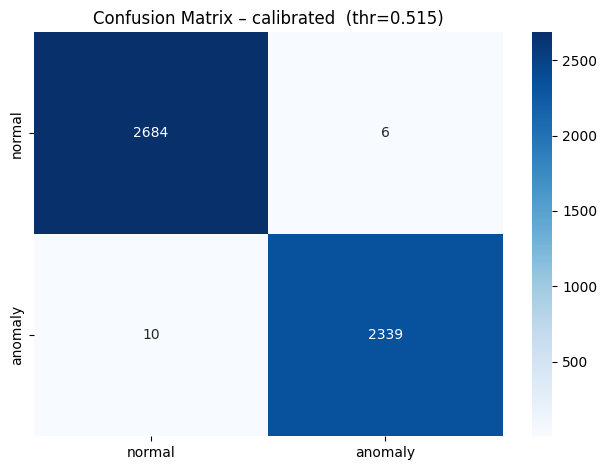

In [138]:
cm = metrics.confusion_matrix(y_te, y_pred_test, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal','anomaly'],
            yticklabels=['normal','anomaly'])
plt.title(f'Confusion Matrix – calibrated  (thr={thr_opt:.3f})')
plt.tight_layout(); plt.show()

## 3.3 Classificação com Regressão Logística e Grid Search

Aqui vamos colocar uma regressão logística para agir em conjunto com o XGB, nesse caso é como se os dois rodassem e apontassem quando vissem uma anomalia, a partir disso podemos ter mais noção de pequenos fatores que possam estar afetando o outro modelo, principalmente features na qual uma pequena ordinalidade altere a inferência. Primeiro vamos rodar somente a regressão logística para conferir sua acurácia. No entanto, matematicamente, como o fator de peso pra anomalia é maior na regressão logística, é muito capaz que esse modelo nos aponte eventuais overfits por disparar indiscriminadamente.

In [139]:
poly_pipe = Pipeline([
        ('prep',    prep),                               
        ('impute',  SimpleImputer(strategy='median')),   
        ('poly',    PolynomialFeatures(degree=2,
                                       interaction_only=True,
                                       include_bias=False)),
        ('model',   LogisticRegression(max_iter=2000,
                                       class_weight='balanced',
                                       n_jobs=-1,
                                       C=2.0,
                                       solver='lbfgs'))
])

lr_cal = CalibratedClassifierCV(poly_pipe, method='isotonic', cv=3, n_jobs=-1)
lr_cal.fit(X_tr, y_tr)

CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('svc',
                                                                                   TargetEncoder(cols=['service'],
                                                                                                 handle_unknown='ignore',
                                                                                                 smoothing=0.3),
                                                                                   ['service']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['protocol_type',
                                                                                    'flag']),
                                                                                  ('num',
                                                                                   StandardScaler(),
                                                                                   ['duration',
                                                                                    'src_bytes',
                                                                                    'dst_bytes',
                                                                                    'land',
                                                                                    'wrong_fragment',
                                                                                    'urgent',
                                                                                    '...
                                                                                    'dst_host_srv_count',
                                                                                    'dst_host_same_srv_rate',
                                                                                    'dst_host_diff_srv_rate',
                                                                                    'dst_host_same_src_port_rate',
                                                                                    'dst_host_srv_diff_host_rate'])])),
                                                 ('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True)),
                                                 ('model',
                                                  LogisticRegression(C=2.0,
                                                                     class_weight='balanced',
                                                                     max_iter=2000,
                                                                     n_jobs=-1))]),
                       method='isotonic', n_jobs=-1)

Aqui temos a configuração do grid search para os limites de cada modelo, isso é  feito antes somente porque eu preciso do valor do limite desse modelo para rodar a regressão logística sozinha e também no formato grid search(que está dentro do for loop)
O objetivo aqui é como o anterior, minimizar o custo(10 para falsos negativos e 1 para falsos positivos)

In [140]:
prob_val_xgb = calibrated_pipe.predict_proba(X_val)[:, 1]
prob_val_lr  = lr_cal.predict_proba(X_val)[:, 1]

thr_grid   = np.linspace(0.2, 0.9, 36)          
best_cost  = 1e9
best_pair  = (0.5, 0.5)

for tx in thr_grid:                             
    bx = (prob_val_xgb >= tx).astype(int)
    for tl in thr_grid:                         
        bl   = (prob_val_lr >= tl).astype(int)
        vote = np.logical_or(bx, bl)            
        fn   = ((vote==0) & (y_val==1)).sum()
        fp   = ((vote==1) & (y_val==0)).sum()
        cost = 10*fn + fp                       
        if cost < best_cost:
            best_cost, best_pair = cost, (tx, tl)

thr_xgb, thr_lr = best_pair
print(f"Limites escolhidos  XGB={thr_xgb:.2f}  LR={thr_lr:.2f}")

Limites escolhidos  XGB=0.20  LR=0.90


### 3.3.1 Resultados com Regressão Logística

In [141]:
prob_test_lr  = lr_cal.predict_proba(X_te)[:, 1]
y_pred_lr     = (prob_test_lr >= thr_lr).astype(int)

print("\n=== Regressão Logística ===")
print(classification_report(y_te, y_pred_lr,
                            target_names=['normal','anomaly']))
roc  = metrics.roc_auc_score(y_te, prob_test_lr)
pr   = metrics.average_precision_score(y_te, prob_test_lr)
print(f"ROC‑AUC : {roc:.4f}")
print(f"PR‑AUC  : {pr :.4f}")


=== Regressão Logística ===
              precision    recall  f1-score   support

      normal       0.98      1.00      0.99      2690
     anomaly       1.00      0.97      0.98      2349

    accuracy                           0.98      5039
   macro avg       0.99      0.98      0.98      5039
weighted avg       0.99      0.98      0.98      5039

ROC‑AUC : 0.9981
PR‑AUC  : 0.9971


Regressão logística funciona um pouco diferente de XGB, essencialmente eles se complementam no fato que um utiliza um threshold alto pra controlar falsos positivos, enquanto o XGB utiliza um mais baixo para evitar ataques de baixa probabilidade(ou que a inferência no caso seria baixa), esses resultados foram melhorados(anteriormente a taxa de falsos negativos era muito maior) pelo uso do parametro de classes polinomiais:

        ('poly',    PolynomialFeatures(degree=2,
                                       interaction_only=True,
                                       include_bias=False)),

Por que?

Provavelmente um fator anteriormente visto aqui é a correlação entre duas variáveis ser muito forte, como filtramos em nosso EDA, porém filtramos com o threshold de 90%, ainda é possível que existam mais variáveis correlacionadas que causem iterações em pares. Essa é a desvatagem de não ter utilizado nenhum modelo de árvore, já que eles que conseguem melhor captar essas disparidades.

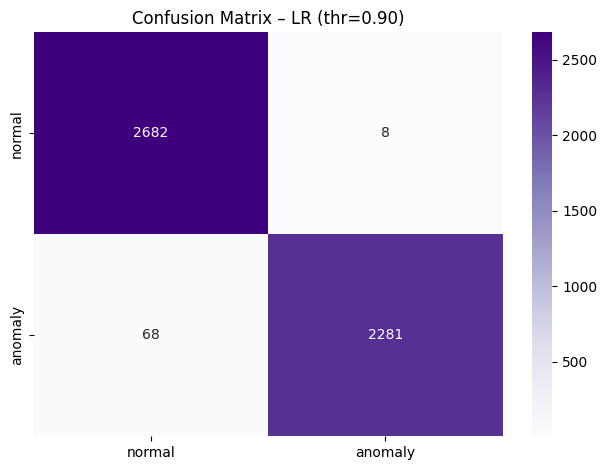

In [142]:
cm_lr = metrics.confusion_matrix(y_te, y_pred_lr, labels=[0,1])
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples',
            xticklabels=['normal','anomaly'],
            yticklabels=['normal','anomaly'])
plt.title(f'Confusion Matrix – LR (thr={thr_lr:.2f})')
plt.tight_layout(); plt.show()

### 3.3.2 Resultados com o Grid Seach(Regressão Logística e XGB)

In [143]:
prob_test_xgb = calibrated_pipe.predict_proba(X_te)[:, 1]
prob_test_lr  = lr_cal.predict_proba(X_te)[:, 1]
prob_ens = np.maximum(prob_test_xgb, prob_test_lr)
roc_ens = metrics.roc_auc_score(y_te, prob_ens)
pr_ens  = metrics.average_precision_score(y_te, prob_ens)

vote_test = np.logical_or(prob_test_xgb >= thr_xgb,
                          prob_test_lr  >= thr_lr).astype(int)

print(classification_report(y_te, vote_test,
                            target_names=['normal','anomaly']))
print(f"Ensemble ROC‑AUC : {roc_ens:.4f}")
print(f"Ensemble PR‑AUC  : {pr_ens :.4f}")

              precision    recall  f1-score   support

      normal       1.00      0.99      0.99      2690
     anomaly       0.99      1.00      0.99      2349

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039

Ensemble ROC‑AUC : 0.9990
Ensemble PR‑AUC  : 0.9980


Aqui conseguimos alcançar nossa rígida sensibilidade de 0,2%, os dois modelos juntos acabam por disparar um ataque com chances marginais, tendo o XGB acusando uma anomalia muito facilmente(threshold de 20%) enquanto a regressão só aplica quando tem uma alta de probabilidade(threshold de 90%), diminuindo  falsos negativos para somente 7-9(variável entre testes), o mais baixo de todas as métricas, isso implicam junto as métricas de ROC e PR que temos um modelo estável para este dataset em específico, precisando somente talvez ajustar o threshold de ambos para uma solução extremamente arrojada.

Mas e se quisessemos testar o mesmo modelo, numa situação na qual os dados de ataques estão em constante mudança? Assim como em ataques de code injection, apenas uma pequena mudança no PE header de um arquivo muda totalmente o hash do programa, pequenas mudanças na estratégia de ataque ocorrem o tempo todo, por isso passamos para a etapa de Data Augmentation.

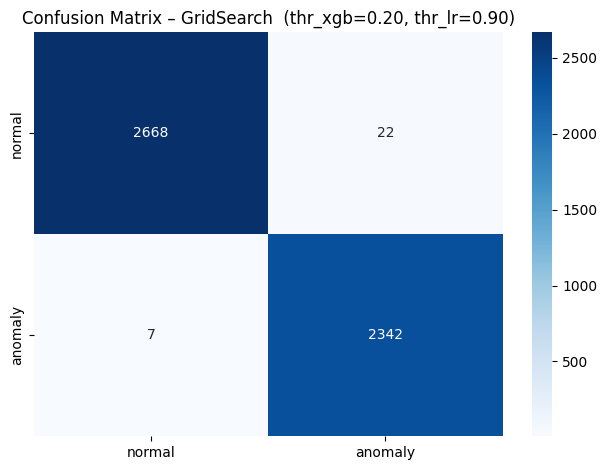

In [144]:
cm = metrics.confusion_matrix(y_te, vote_test, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal','anomaly'],
            yticklabels=['normal','anomaly'])
plt.title(f'Confusion Matrix – GridSearch  (thr_xgb={thr_xgb:.2f}, thr_lr={thr_lr:.2f})')
plt.tight_layout(); plt.show()

# 4. Data Augmentation

Aqui vamos fazer algo diferente, vamos adicionar um pouco de ruído utilizando uma técnica estatística chamada ruído gaussiano, vamos pegar o desvio padrão das colunas numéricas e aplicar uma pequena alteração de valor +- 2% para simular o que seria um novo tipo de ataque, assim como as categóricas que sofrem uma alteração de 0.5% de sua assinatura(o que seria comum num exemplo de spoofing) a partir disso, testar a robustez de nosso modelo.

In [145]:
inner_pipe    = calibrated_pipe.estimator
prep_step     = inner_pipe.named_steps['prep']
feature_names = prep_step.get_feature_names_out()

In [146]:
prob_clean = calibrated_pipe.predict_proba(X_te)[:, 1]
y_pred_clean = (prob_clean >= thr_opt).astype(int)

In [147]:
#aqui fazemos um array denso de anomailias
X_test_trans = prep_step.transform(X_te)
X_dense = X_test_trans.toarray() if issparse(X_test_trans) else X_test_trans.copy()

#Vamos pegar as colunas numéricas e calcular o desvio padrão para então aplicar abaixo
num_mask = np.array([name.startswith('num__') for name in feature_names])
std      = X_dense[:, num_mask].std(axis=0, ddof=0)
rng      = np.random.default_rng(42)

#Aqui aplicamos uma pertubação gaussana nas colunas numéricas com 2% de ruído
#a mais somente com um flip de 0,5% 
noise    = rng.normal(0, 0.02 * std, size=X_dense[:, num_mask].shape)  # ±2 % σ
X_dense[:, num_mask] += noise
cat_mask = ~num_mask

#Alterando bits em colunas
cat_cols_idx = np.where(cat_mask)[0]
rows, cols = np.where(X_dense[:, cat_mask] == 1)
flip_n     = int(0.005 * len(rows))          
idx        = rng.choice(len(rows), flip_n, replace=False)

for r, c_sub in zip(rows[idx], cols[idx]):
    c_abs = cat_cols_idx[c_sub]              
    X_dense[r, c_abs] = 0                    
    alt_abs = rng.choice(cat_cols_idx)
    X_dense[r, alt_abs] = 1
    
prob_adv = inner_pipe.named_steps['model'].predict_proba(X_dense)[:, 1]
y_pred_adv = (prob_adv >= thr_opt).astype(int)

In [148]:
print("==== CLEAN TEST ====")
print(classification_report(y_te, y_pred_clean, target_names=['normal','anomaly']))

print("\n==== ADVERSARIAL TEST ====")
print(classification_report(y_te, y_pred_adv, target_names=['normal','anomaly']))

cm_clean = metrics.confusion_matrix(y_te, y_pred_clean, labels=[0,1])
cm_adv   = metrics.confusion_matrix(y_te, y_pred_adv,   labels=[0,1])

rec_drop = (cm_clean[1,1] - cm_adv[1,1]) / cm_clean[1,1] * 100
prec_clean = cm_clean[1,1] / (cm_clean[0,1] + cm_clean[1,1])
prec_adv   = cm_adv  [1,1] / (cm_adv  [0,1] + cm_adv  [1,1])
prec_drop  = (prec_clean - prec_adv) * 100

print(f"\nRecall drop : {rec_drop:.2f}%")
print(f"Precision drop : {prec_drop:.2f}%")

==== CLEAN TEST ====
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      2690
     anomaly       1.00      1.00      1.00      2349

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039


==== ADVERSARIAL TEST ====
              precision    recall  f1-score   support

      normal       0.93      0.90      0.92      2690
     anomaly       0.89      0.92      0.91      2349

    accuracy                           0.91      5039
   macro avg       0.91      0.91      0.91      5039
weighted avg       0.91      0.91      0.91      5039


Recall drop : 7.65%
Precision drop : 10.45%


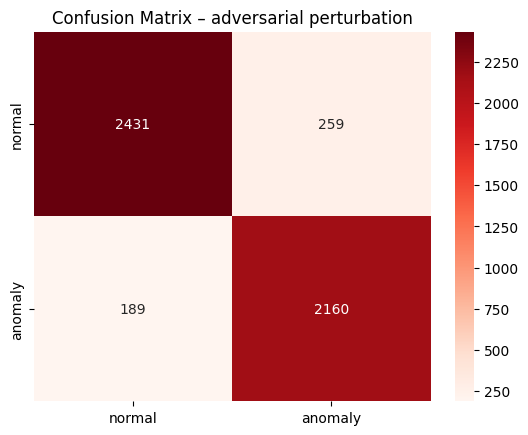

In [149]:
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Reds',
            xticklabels=['normal','anomaly'],
            yticklabels=['normal','anomaly'])
plt.title('Confusion Matrix – adversarial perturbation'); plt.show()

Com isso vemos que existe uma fragilidade em montar um modelo tão sensível assim, pequenas mudanças nos dados, principalmente com colunas tão variáveis como as de count que vimos acima e é o suficiente para pertubar a capacidade de predição por um todo, por isso é muito importante existir um trabalho constante em unir vários modelos para construir um algorítmo tanto robusto quanto maleável(como a água como Bruce Lee diria), nesse caso somente testei a interferência com o XGB calibrado para um threshold de 0.6, então é esperado que ele seja tão pertubado assim, mas para uma eventual tarefa seria ideal poder utilizar XGB+LR aqui também, ou até mesmo uma IsolationForest que também seria bastante maleável.

# 5. Relatórios e Aprendizados

Com isso utilizamos alguns artificios que de certa forma não dependem do modelo que usamos para guardar os recursos adquiridos nessa atividade, aqui utilizei um um sumário SHAP, que guarda Shapley values o que nos ajuda a identificar as classes que realmente fizeram o modelo ter as inferências que teve em nossos testes(diferente da feature importance, que é um valor de aferição, esse é diretamente para a observação do teste), com isso podemos corrigir algumas interações não planejadas anteriormente(como eu mesmo tive de fazer várias vezes na construção desse trabalho)

In [150]:
bg_idx  = np.random.choice(X_tr.index, 500, replace=False)
X_bg_t  = inner_pipe.named_steps['prep'].transform(X_tr.loc[bg_idx])
X_ex_t  = inner_pipe.named_steps['prep'].transform(X_te.head(200))
expl    = shap.TreeExplainer(inner_pipe.named_steps['model'])
sv      = expl.shap_values(X_ex_t)

feat_nms = inner_pipe.named_steps['prep'].get_feature_names_out()


In [151]:
plt.figure()
shap.summary_plot(sv, X_ex_t, feature_names=feat_nms,
                  max_display=20, show=False)          
png_path = "shap_summary.png"
plt.savefig(png_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved summary plot to {png_path}")

Saved summary plot to shap_summary.png


In [152]:
anom_idx = np.where((y_te==1) & (vote_test==1))[0][0]
html_path = "alert_row{anom_idx}_explanation.html"

shap.save_html(html_path,
               shap.force_plot(expl.expected_value,
                               sv[anom_idx, :],
                               X_ex_t[anom_idx, :],
                               feature_names=feat_nms))

Aqui também guardaremos os modelos usados, calibração e threshold para caso necessário em usos futuros não termos de treinar novamente, algo muito comum no cenário industrial onde podemos simplesmente alterar esses valores na pipeline sem ter de interagir diretamente com o modelo.

In [153]:
joblib.dump({
    'xgb_model' : calibrated_pipe,
    'lr_model'  : lr_cal,
    'thr_xgb'   : float(thr_xgb),
    'thr_lr'    : float(thr_lr),
    'feature_names': feat_nms       
}, 'ids_or_ensemble_2025‑05‑02.job')

['ids_or_ensemble_2025‑05‑02.job']